<a href="https://colab.research.google.com/github/JpChii/ML-Projects/blob/main/09_skim_lit_40k_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Setting up extensions
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [this notebook](https://github.com/JpChii/ML-Projects/blob/main/09_SkimLit_milestone_project.ipynb), Created and ran a series of experiments to find a model that's performaing well. The notebook uses these two papers below,

1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

In this notebook, we'll create and train our best model on the 200k dataset. If we can see any improvements.

# Creating and training our tribrid model on full 200k pubmed dataset

We're going to replicate the below architecture. Let's fix desired accuracy at 90%, if it's not performing up to the mark. we'll think of the next steps after that.

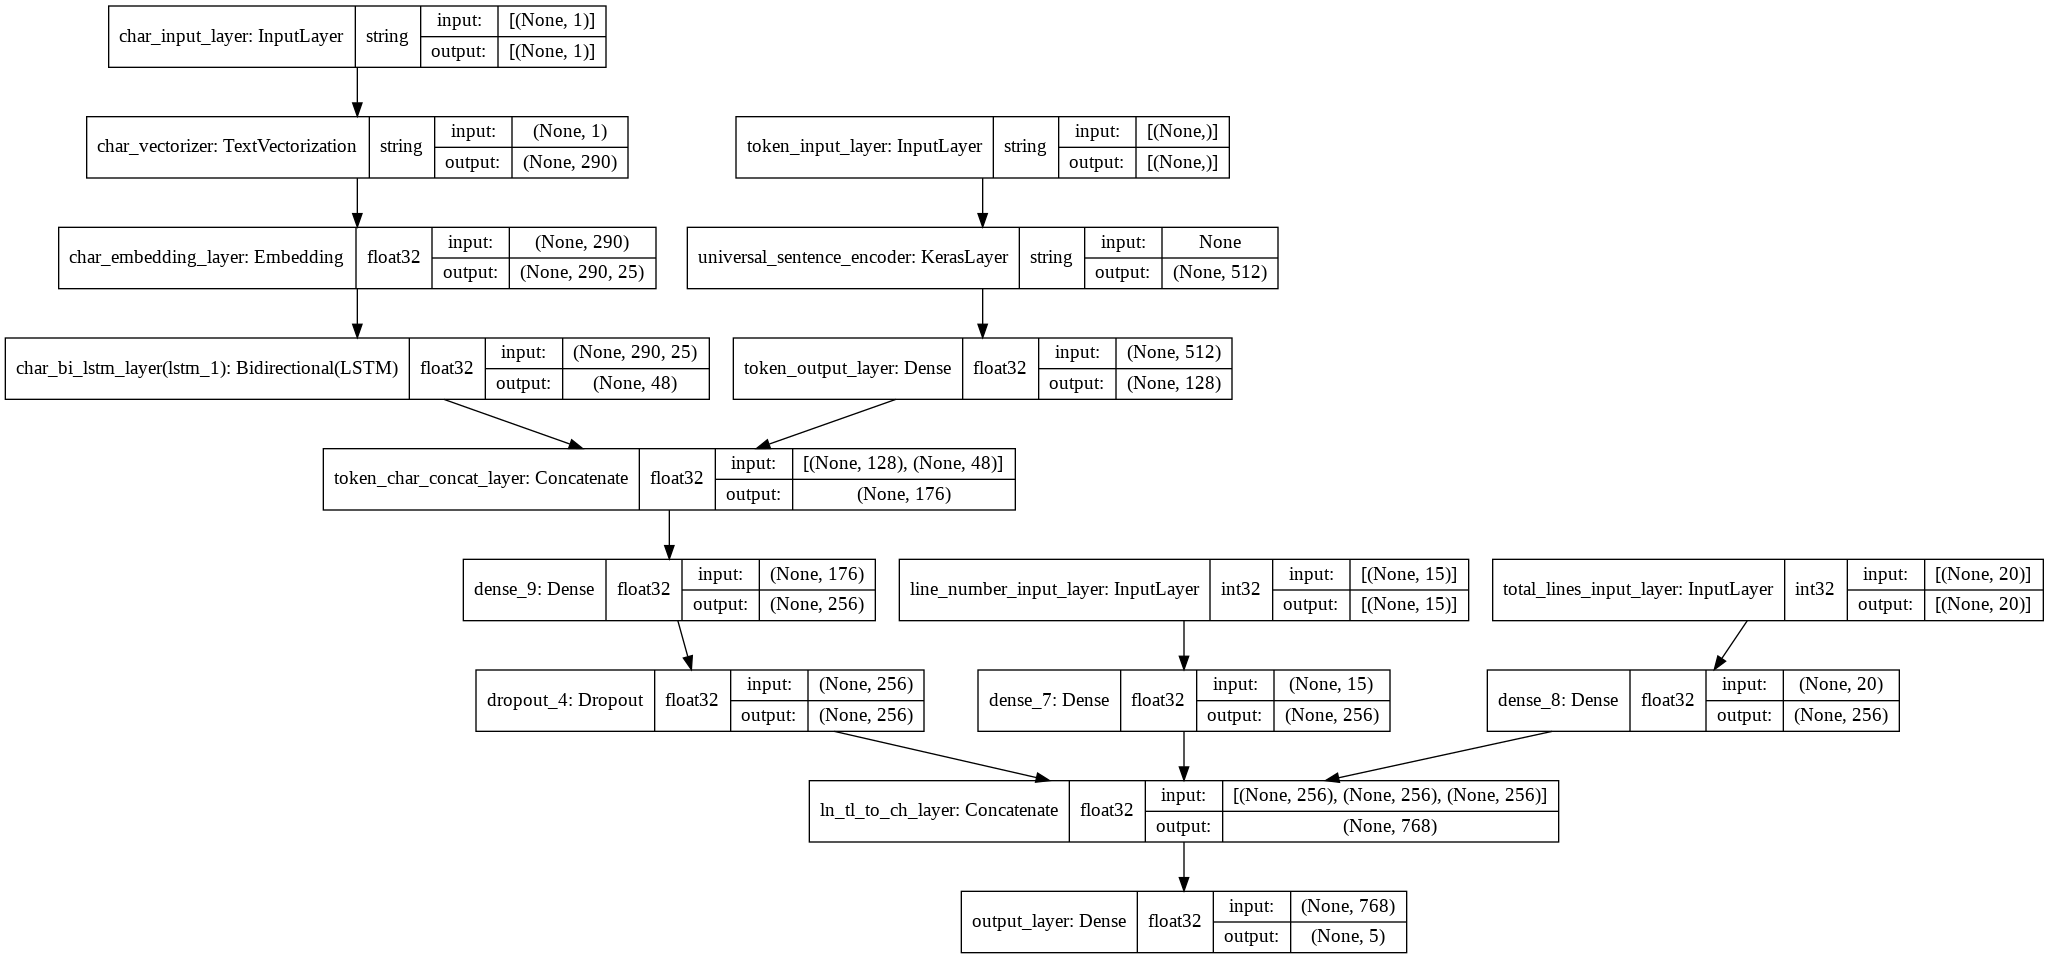

## Get the data

In the introduction section of the [dataset paper](https://arxiv.org/pdf/1710.06071.pdf) we can find the github link to download the data.

[Data github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [9]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


### Get helper function

In [3]:
!wget https://raw.githubusercontent.com/JpChii/ML-Tools/main/dl_helper.py

--2021-06-11 05:11:20--  https://raw.githubusercontent.com/JpChii/ML-Tools/main/dl_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17973 (18K) [text/plain]
Saving to: ‘dl_helper.py’

dl_helper.py        100%[===================>]  17.55K  --.-KB/s    in 0s      

2021-06-11 05:11:21 (67.9 MB/s) - ‘dl_helper.py’ saved [17973/17973]



In [4]:
from dl_helper import walk_through_dir

In [5]:
# Checkout the cloned repo directory
!ls "/content/pubmed-rct"

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Okay, so we have 20k and 200k dataset with two variants. In out parent notebook we've used `PubMed_20k_RCT_numbers_replaced_with_at_sign` and we'll use `PubMed_200k_RCT_numbers_replaced_with_at_sign` for comparison with previous models.

In [6]:
# Chekout the 200RCT data directory
walk_through_dir("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign")

There are 0 directories and 3 images in '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign'.


In [7]:
# Check the contents of the directory
!ls "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

dev.txt  test.txt  train.zip


We've three files for val(dev), train and test. Let's write some functions to preprocess these data.

## Preprocessing data

In this section we'll get the data from text file into pandas dataframe.

In [10]:
# Creating a function to read the document and put into a list
def get_lines(filename):
  """
  Reads a file and returns the lines of text as a list
  """

  with open(filename, "r") as f:
    return f.readlines()

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a lsit of dictionaries of abstract line data
  """

  # Get all the lines into a list
  input_lines = get_lines(filename)
  # Create an emty abstract
  abstract_lines = ""
  # Create an empty list of abstracts
  abstract_samples = []

  # Loo[ through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # reset the abstract string in the line if it's an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # Split abstract into seperate lines

      # Iterate through each line in abstract lines and add line number and total lines
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # Split the data since they are seperate by tab
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() # Get target text and lower it
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [12]:
# Unzip train.zip
from dl_helper import unzip_data
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

In [13]:
train_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [14]:
!mv "/content/train.txt" "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

In [15]:
# Let's read in the training data
train_dict = preprocess_text_with_line_numbers(train_dir + "train.txt")

In [16]:
# Get val and test data as well 
val_dict = preprocess_text_with_line_numbers(train_dir + "dev.txt")
test_dict = preprocess_text_with_line_numbers(train_dir + "test.txt")

In [17]:
# Check the length of the dict
len(train_dict), len(val_dict), len(test_dict)

(2211861, 28932, 29493)

We've got huge amount of data.

In [18]:
import pandas as pd
# Convert the data to pandas dataframes
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

In [19]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


After creating text vectorizer for character embedding and during `.adapt()`, method colab ran out of memory and kept crashing in the adapt cell. So we cannot traing the model with 200k dataset in free tier of colab even with GPU. So instead of full dataset. We'll go with 40% of the 200k dataset,

## Creating 40% PubMed dataset

In [20]:
from sklearn.model_selection import train_test_split
train_40_per_df, train_60_per_df = train_test_split(train_df, test_size=0.6)
val_40_per_df, val_60_per_df = train_test_split(val_df, test_size=0.6)
test_40_per_df, val_40_per_df = train_test_split(test_df, test_size=0.6)

In [21]:
len(train_df), len(train_40_per_df) + len(train_60_per_df), len(train_40_per_df), len(train_60_per_df)

(2211861, 2211861, 884744, 1327117)

## Turning data into numbers

Machine's hate text and love numbers, so right now our labels(`target`) and feature(`text`) are in text. We'll convert this to numbers.

In [22]:
# Distribution of labels in training daa
label_dist = pd.DataFrame(train_40_per_df.target.value_counts().reset_index())
label_dist

,index,target
0,RESULTS,306607
1,METHODS,289308
2,CONCLUSIONS,135566
3,BACKGROUND,78583
4,OBJECTIVE,74680


### Visualizing label distribution

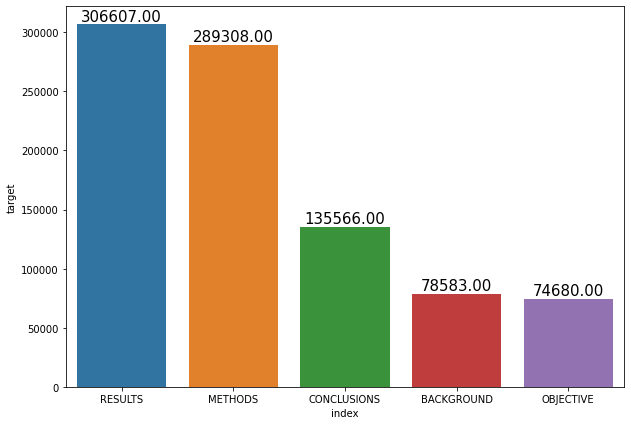

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
plot = sns.barplot(x="index", y="target", data=label_dist)

# Iterating over bars one by one
for bar in plot.patches:
  plot.annotate(format(bar.get_height(), '.2f'), # gets the value
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), # point in the plot fot text
                ha='center',
                va='center',
                size=15,
                xytext=(0,8),
                textcoords='offset points')
  
plt.show()

In [24]:
306557 / 74529

4.1132579264447395

There's a difference in labels but not huge like 10x or 100x only 4x.

### Turning our target label into numbers

We're going to one_hot encode our labels

In [25]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [26]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_40_per_df.target.to_numpy().reshape(-1,1)) # reshape(-1,1) we're asking numoy to determine the output shape of onehot encoding based on the categoricals
val_labels_one_hot = one_hot_encoder.transform(val_40_per_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_40_per_df.target.to_numpy().reshape(-1,1))

In [27]:
train_labels_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

So, now the labels are converted to numbers. Next step is to convert text to numbers. The efficient way to convert learnable weights of our model is via embeddings.  Based on our best performing tribrid architecture. 

We need,

1. Token embeddings
      * For token embeddings we're going to use pretrained embeddings of `universal sentence encoder` from `TensorFlow Hub`. For this we just need a list of sentences.
2. Character embeddings
      * For character embedding, we're using custom embeddings layer. First we'll convert list of sentences to characters
      * Convert characters to integers using `TextVectorization`
      * Pass the vectors to `Custom embedding layer`
3. Positional embeddings
      * For positinal embeddings, we're gonna one-hot encode `line_number` and `total_lines` features.

Based on this the things we've to do next before proceesding with embeddings are,

1. Put sentences into a list
2. Convert sentencesw to characters


In [28]:
# Convert sentences into a list
train_sentences = train_40_per_df.text.to_list()
val_sentences = val_40_per_df.text.to_list()
test_sentences = test_40_per_df.text.to_list()

In [29]:
train_sentences[0]

'herein we report our experience of patients treated with the mp and conventional approach .'

In [30]:
# Convert sentences to characters
def get_chars(text):
  return " ".join(list(text))

In [31]:
get_chars(train_sentences[0])

'h e r e i n   w e   r e p o r t   o u r   e x p e r i e n c e   o f   p a t i e n t s   t r e a t e d   w i t h   t h e   m p   a n d   c o n v e n t i o n a l   a p p r o a c h   .'

In [32]:
# Use the function and create chars list
train_chars = [get_chars(sentence) for sentence in train_sentences]
val_chars = [get_chars(sentence) for sentence in val_sentences]
test_chars = [get_chars(sentence) for sentence in test_sentences]
train_chars[0]

'h e r e i n   w e   r e p o r t   o u r   e x p e r i e n c e   o f   p a t i e n t s   t r e a t e d   w i t h   t h e   m p   a n d   c o n v e n t i o n a l   a p p r o a c h   .'

Now we've the list of sentences and characters

## Embeddings

Now we've all the stuff ready, let's create some embeddings

### Pretrained Token Embeddings

We'll use [Universal sentence encoder from tensorflow hub](https://tfhub.dev/google/universal-sentence-encoder/4)

In [33]:
import tensorflow_hub as hub
import tensorflow as tf
universal_sentence_encoder = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                                            trainable=False,
                                            input_shape=[],
                                            dtype=tf.string)

### Character Embeddings

For character embeddings, first we have to convert characters to numbers.

#### Character Vectorizer

In [34]:
# Let's get all the different characters
# Since we're going to strip punctuation and numbers are already replaced by @, We'll include only the alphabets and special characters for out max tokens size
import string
char_tokens = string.ascii_lowercase
char_tokens

'abcdefghijklmnopqrstuvwxyz'

In [35]:
len(char_tokens)

26

In [36]:
# LEt's get the output sequence length for vectorizer
import numpy as np
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

147.76206111598384

In [37]:
char_lens[0], len(train_sentences[0]), len(train_chars[0]) # Length of train_chars won;t give us the correct length since we're joining each charcter with a space before it

(91, 91, 181)

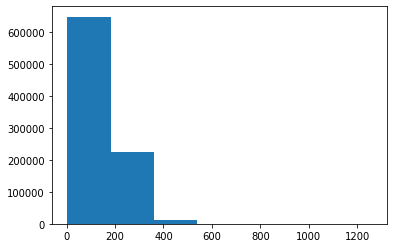

In [38]:
# Check the distribution of character length across sentences
plt.hist(char_lens, bins=7);

In [39]:
# Use percentile to find the length of 95%
output_char_seq_len =int(np.percentile(char_lens, 95))
output_char_seq_len

283

In [40]:
# Create vectorizer
NUM_CHAR_TOKENS = len(char_tokens) + 2
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vectorizer_character = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  # num chars in alphabets + space + oov
                                         output_sequence_length=output_char_seq_len,
                                         name="char_vectorizer_layer")

> **Note:** adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

In [41]:
%%time
# Adapt the text vectrorizer to train_chars
vectorizer_character.adapt(train_chars)

CPU times: user 4min, sys: 3.95 s, total: 4min 4s
Wall time: 4min 3s


In [42]:
len(train_chars)

884744

In [43]:
# Check out the vocabulary
rct_80k_char_vocab = vectorizer_character.get_vocabulary()
print(f"Length of the vocabulay: {len(rct_80k_char_vocab)}")
print(f"Most frequent chars: {rct_80k_char_vocab[:5]}")
print(f"Least Frequent chars: {rct_80k_char_vocab[-5:]}")

Length of the vocabulay: 28
Most frequent chars: ['', '[UNK]', 'e', 't', 'a']
Least Frequent chars: ['k', 'x', 'z', 'q', 'j']


Now the vectorizer is done, let's create character embedding layer

#### Custom character Embedding

In [44]:
embedding_character = tf.keras.layers.Embedding(input_dim=len(rct_80k_char_vocab),
                                                output_dim=25, # IS the character embedding dimension used in the paper
                                                mask_zero=True)

Now token embedding and charcter embedding are done. Now let's next move onto positonal embeddings.

### Positional embedding

As Positional embedding, we alredy have the features `line_number` and `total_lines` as numerical. Let;s just one-hot encode them and move on to modelling.

1. One-hot encode line_number
2. One-hot enocde toal_line

#### One-Hot encode line_number

In [45]:
# Check the value counts of line number
train_40_per_df.line_number.value_counts()

1     76482
2     76195
3     76145
0     76076
5     76064
4     75927
6     74046
7     71444
8     65655
9     57482
10    47384
11    35756
12    25870
13    17649
14    11827
15     7483
16     4711
17     3010
18     1903
19     1191
20      769
21      506
22      326
23      226
24      156
25      120
26       83
27       51
28       47
29       41
30       25
31       21
32       15
35        9
34        9
33        9
36        7
37        5
39        5
38        4
42        2
43        2
45        1
46        1
47        1
44        1
40        1
48        1
Name: line_number, dtype: int64

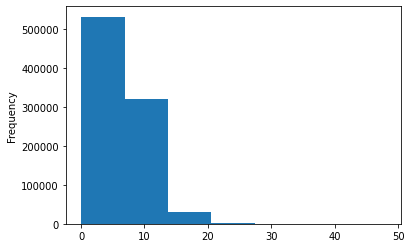

In [46]:
# Check the distribution
train_40_per_df.line_number.plot(kind="hist", bins=7);

In [47]:
# Check the 98 percentile to be used as the depth of the one-hot encoding
line_number_one_hot_depth = int(np.percentile(train_40_per_df.line_number, 98))
line_number_one_hot_depth

15

In [48]:
# One-hot encode
train_line_numbers_one_hot = tf.one_hot(train_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
val_line_numbers_one_hot = tf.one_hot(val_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
test_line_numbers_one_hot = tf.one_hot(test_40_per_df.line_number.to_numpy(), depth=line_number_one_hot_depth)
train_line_numbers_one_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

Now line number is completed, let's do the same for total lines.

#### One-Hot encode total_lines

In [49]:
# Check the value counts of total lines
train_40_per_df.total_lines.value_counts()

10    121873
11    121599
12    106601
9     103639
13     85159
8      73268
14     62211
15     44566
7      43985
16     30194
6      21262
17     19485
18     12682
19      8807
5       8397
20      5551
21      4015
4       2565
22      2275
23      1629
24      1111
25       818
26       578
27       485
3        439
28       371
29       302
31       168
33       168
30       121
32        88
35        74
34        50
37        44
36        38
45        21
43        20
46        19
2         17
49        17
40        16
50        16
Name: total_lines, dtype: int64

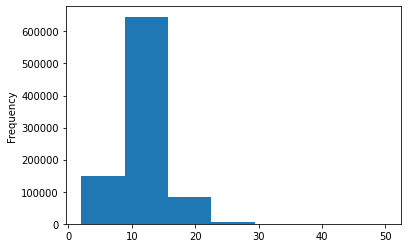

In [50]:
# Checkout the distribution
train_40_per_df.total_lines.plot(kind="hist", bins=7)

In [51]:
# Get the 98th percentile for one hot encode depth
total_lines_one_hot_encode_depth = int(np.percentile(train_40_per_df.total_lines, 98))
total_lines_one_hot_encode_depth

20

In [52]:
# Let's encode them
train_total_lines_one_hot = tf.one_hot(train_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
val_total_lines_one_hot = tf.one_hot(val_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
test_total_lines_one_hot = tf.one_hot(test_40_per_df.total_lines, depth=total_lines_one_hot_encode_depth)
train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

Now we've all the embeddings ready. Nex step is to prepate the data to be loaded efficiently into GPU's memory and fast training. Since we're dealing with huge data, we'll write some callbacks as well.

Next steps will be,

1. Setup Mixed precison - model layers will use lower precision whenever possible without affecting the numericaL stability
2. Build the model from our tribrid architecture
3. Create fast loading `tf.data.Dataset`
4. Train the model
5. Evaluate the model

## Modelling

### Setting up mixed precision

In [53]:
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


### Building the model

In [54]:
# Imports
from tensorflow.keras import layers

In [55]:
# 1. Token level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input_layer") # Input shape is list because unviersal sentence encoder accepts a list of sentences and return 512 dimension embedding
embeds_token = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output_layer")(embeds_token)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs,
                             name="token_level_model")

In [56]:
# 2. Character level model
char_input = layers.Input(shape=(1, ), dtype=tf.string, name="char_input_layer")
vectors_char = vectorizer_character(char_input)
embeds_char = embedding_character(vectors_char)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(embeds_char)
char_model = tf.keras.Model(inputs=char_input,
                            outputs=char_bi_lstm,
                            name="char_level_model")

In [57]:
# 3. Line number mode
line_number_input = layers.Input(shape=(line_number_one_hot_depth,), dtype=tf.float16, name="line_no_input_layer")
line_number_output = layers.Dense(256, activation="relu", name="line_no_output_layer")(line_number_input)
line_number_mode = tf.keras.Model(inputs=line_number_input,
                                  outputs=line_number_output,
                                  name="line_no_model")

In [58]:
# 4. Total lines model
total_lines_input = layers.Input(shape=(total_lines_one_hot_encode_depth,), dtype=tf.float16, name="total_lines_input_layer")
total_lines_output = layers.Dense(256, activation="relu", name="total_lines_output_layer")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output,
                                   name="total_lines_model")

In [59]:
# 5. Concatenate token level and character level outputs
z = layers.Concatenate(name="token_char_concat_layer")([token_model.output, char_model.output])

In [60]:
# 6. Add a dense layer and droput as mentioned in the paper after concatenation
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.5)(z) # dropout layer for regulariation(to prevent overfitting, forcing the model to learn different paths to desired output)

In [61]:
# 7. Concatenate lineno and totalline output with z
ln_tl_to_ch_concat = layers.Concatenate(name="token_char_ln_tl_concat_layer")([line_number_mode.output, total_lines_model.output, z])

In [62]:
# 8. We'll have the activation layers seperate for numerical stability
x = layers.Dense(5, name="final_dense_layer")(ln_tl_to_ch_concat)
output_layer = layers.Activation(activation="softmax", name="output_layer", dtype=tf.float32)(x)

In [63]:
# 9. Building the model
model = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_mode.input, total_lines_model.input],
                       outputs=output_layer)

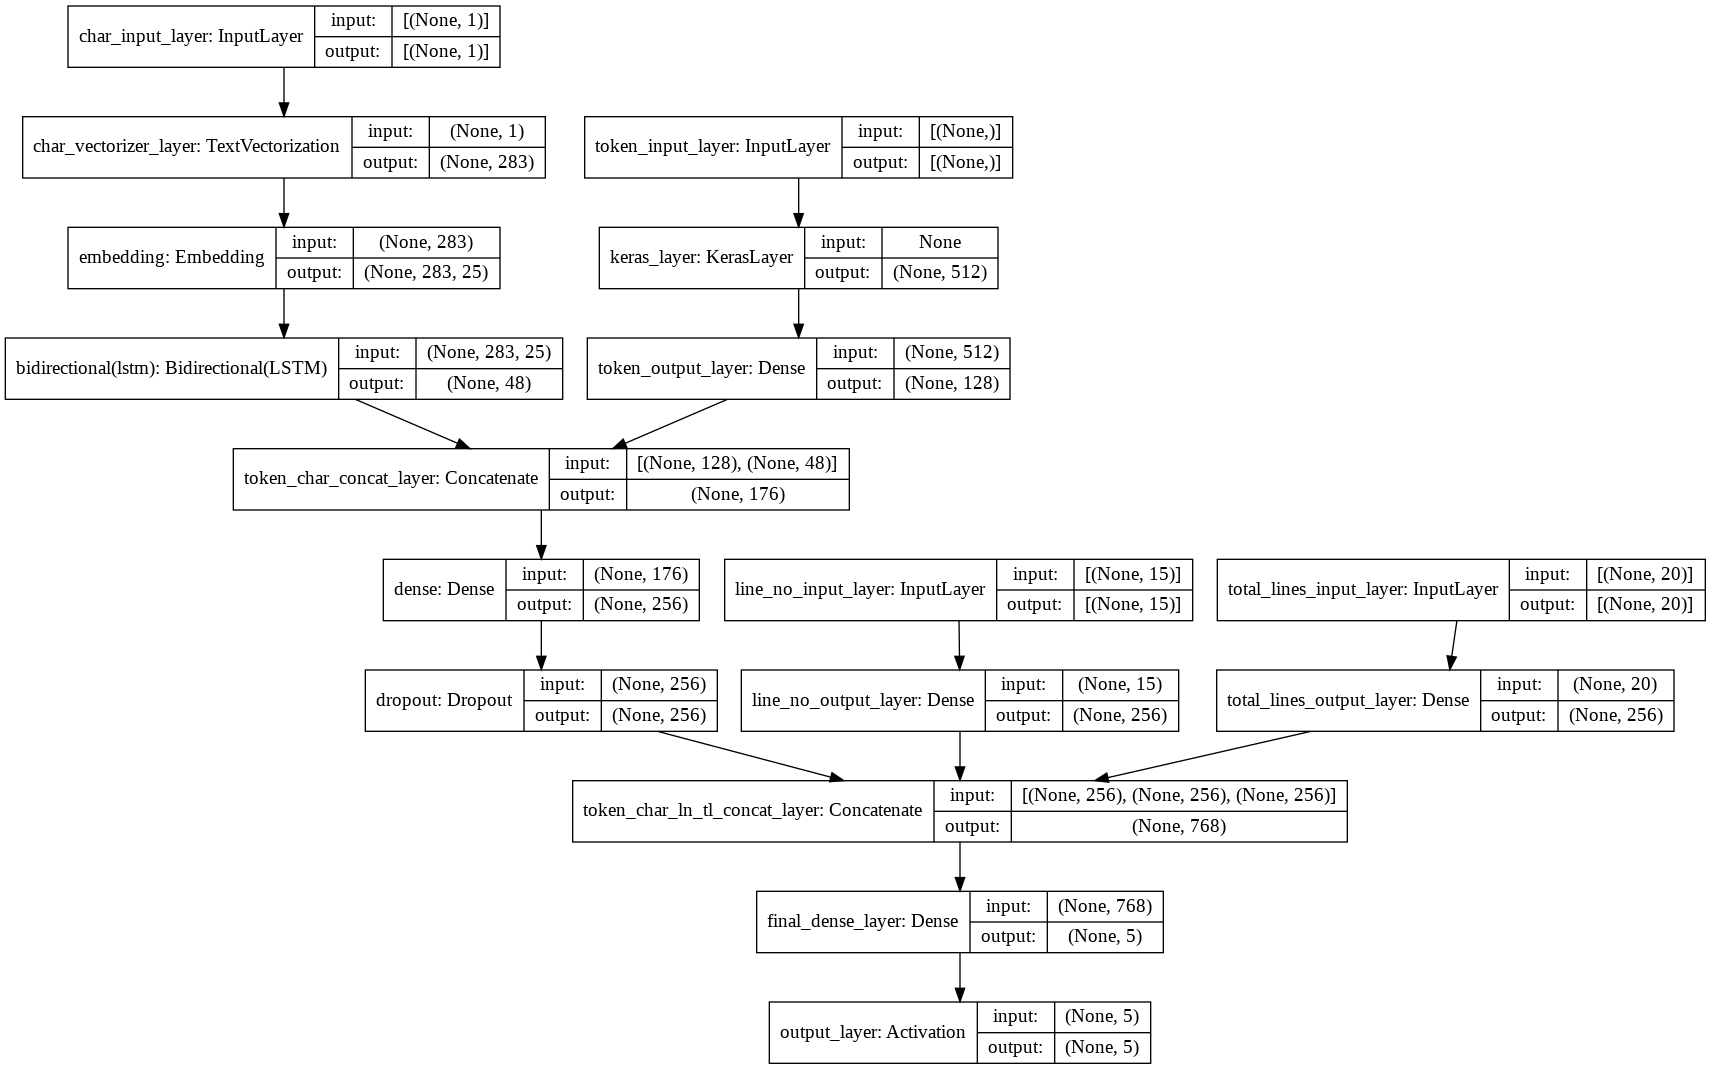

In [64]:
# Checkout the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Look at the beautiful tribrid mode architecture. Now all left is to prepare the dataset and callbacks before training.

## Creating `tf.data` Dataset

The dataset should have the same order the inputs passed to the model.

First we'll convert our data to tensors. We converted our data to list and array for this purpose

In [65]:
# First data
train_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
val_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
test_to_ch_ln_tl_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_numbers_one_hot, test_total_lines_one_hot))

Created a tuple of `(sentencs, chars, line_number, total_lines)` for train, test, val.

Next is the label, label is common for all these four data. Let's create that next

In [66]:
# Labels
train_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
val_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
test_to_ch_ln_tl_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

In [67]:
# Now let's zip data and label together into a single tuple
train_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(train_to_ch_ln_tl_data, train_to_ch_ln_tl_labels))
val_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(val_to_ch_ln_tl_data, val_to_ch_ln_tl_labels))
test_to_ch_ln_tl_dataset = tf.data.Dataset.zip(datasets=(test_to_ch_ln_tl_data, test_to_ch_ln_tl_labels))

train_to_ch_ln_tl_dataset

<ZipDataset shapes: (((), (), (15,), (20,)), (5,)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

In [68]:
model.input_shape

[(None,), (None, 1), (None, 15), (None, 20)]

In [69]:
# Converint ZipDataset to Prefetch dataset
train_to_ch_ln_tl_dataset = train_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_to_ch_ln_tl_dataset = val_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_to_ch_ln_tl_dataset = test_to_ch_ln_tl_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [70]:
train_to_ch_ln_tl_dataset

<PrefetchDataset shapes: (((None,), (None,), (None, 15), (None, 20)), (None, 5)), types: ((tf.string, tf.string, tf.float32, tf.float32), tf.float64)>

Now Dataset is also created, only creation of callbacks is left.

## Creation of callbacks

In [71]:
# Tensorboard callback for logging
from dl_helper import create_tensorboard_callback

In [72]:
# Checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/",
                                                         monitor="val_accuracy",
                                                        verbose=1,
                                                         save_best_only=True,
                                                         save_weights_only=True)

In [73]:
# Early stopping callback
ealy_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3,
                                                          verbose=1)

In [74]:
# Reductin on plateau callback
rl_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                   factor=0.2,
                                                   patience=3,
                                                   verbose=1,
                                                   min_lr=1e-7)

Now all the stuff are done, all left is to compile and train the model.

In [75]:
from dl_helper import save_model

In [76]:
# Compile the mode
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [ ]:
# # Fit the model
# history = model.fit(train_to_ch_ln_tl_dataset,
#                     epochs=5,
#                     validation_data=val_to_ch_ln_tl_dataset,
#                     validation_steps=int(0.1 * len(val_to_ch_ln_tl_dataset))
#                     callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/ML_logs/09_skimlit",
#                                                            experiment_name="tribrid_model_40k_dataset"),
#                                checkpoint_callback,
#                                ealy_stopping_callback,
#                                rl_callback])

Saving TensorBoard log files to: /content/drive/MyDrive/ML_logs/09_skimlit/tribrid_model_40k_dataset/20210610-151546
Epoch 1/10
27649/27649 [==============================] - 1304s 47ms/step - loss: 0.9096 - accuracy: 0.8512 - val_loss: 0.8864 - val_accuracy: 0.8649

Epoch 00001: val_accuracy improved from -inf to 0.86488, saving model to /content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/
Epoch 2/10
27649/27649 [==============================] - 1287s 47ms/step - loss: 0.8889 - accuracy: 0.8654 - val_loss: 0.8786 - val_accuracy: 0.8723

Epoch 00002: val_accuracy improved from 0.86488 to 0.87234, saving model to /content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/
Epoch 3/10
27649/27649 [==============================] - 1297s 47ms/step - loss: 0.8809 - accuracy: 0.8709 - val_loss: 0.8763 - val_accuracy: 0.8723

Epoch 00003: val_accuracy did not improve from 0.87234
Epoch 4/10
27649/27649 [==============================] - 1290s 47ms/step - loss: 0.8759 - accuracy: 0.8743 - va

So training on 40 percent data, we got only 2 percent increase in accuracy with huge increase in training time compared with the previous notebook using 10 percent data. This excercise might've been futile considering we've increased the data 3x. But let's save the model for the time being as it's performing the best for future use. And we also need to figure out if there's a way to configure early stopping callback to ignore decimal changes as improvements.

The training of the big model stopped at 9th epoch due to GPU runtime exceeded in colab. But the weights are stored in `/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per`. We'll load the weights and compare the metrics. If they're not as expected, we've no other way then to retrain the model.

In [78]:
# Load weights
model.load_weights("/content/drive/MyDrive/ML_checkpoints/09_skimlit/40_per/")

In [80]:
# Make some predictions
pred_probs = model.predict(val_to_ch_ln_tl_dataset)
preds = tf.argmax(pred_probs, axis=1)
preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 2, 1, 2, 4])>

In [108]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_40_per_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_40_per_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [109]:
from dl_helper import calculate_results
# Calculate metrics
resutls_40_per = calculate_results(y_true=val_labels_encoded,
                                   y_pred=preds)

In [110]:
resutls_40_per

{'accuracy': 0.8759041591320073,
 'f1': 0.8746010434593687,
 'precision': 0.8747085760351476,
 'recall': 0.8759041591320073}

Okay the accuracy is close to when the training gor interrupted. Let's load in the previous results and compare this.

In [84]:
RESULTS_DF_PATH = "/content/drive/MyDrive/ML_data/skimlit_results.csv"
results_df = pd.read_csv(RESULTS_DF_PATH)
results_df

,Unnamed: 0,baseline,model1_conv1d,model2_use,model3_conv_with_char_embed,model4_tok_plus_char,model5_tribrid_embed
0,accuracy,0.721832,0.755627,0.714815,0.612008,0.731696,0.838078
1,f1,0.698925,0.788440,0.715481,0.613615,0.731157,0.837084
2,precision,0.718647,0.755627,0.714815,0.612008,0.731696,0.838078
3,recall,0.721832,0.764967,0.711805,0.592860,0.728691,0.836908


In [93]:
results_df = results_df.set_index('Unnamed: 0')

In [95]:
results_df["model6_tribrid_40_per"] = resutls_40_per.values()
results_df.T

Unnamed: 0,accuracy,f1,precision,recall
baseline,0.721832,0.698925,0.718647,0.721832
model1_conv1d,0.755627,0.788440,0.755627,0.764967
model2_use,0.714815,0.715481,0.714815,0.711805
model3_conv_with_char_embed,0.612008,0.613615,0.612008,0.592860
model4_tok_plus_char,0.731696,0.731157,0.731696,0.728691
model5_tribrid_embed,0.838078,0.837084,0.838078,0.836908
model6_tribrid_40_per,0.875904,0.874709,0.875904,0.874601


Okay looking at the results dataframe, the training might not've been a complete failure. We've got a 5% increase in accuracy wooooh...!

### Save the model

In [97]:
# Let's save this model
from dl_helper import save_model
SKIM_LIT_MODEL_SAVE_DIR = "/content/drive/MyDrive/ML_models/09_skimlit"
save_model(model=model,
           model_name="tribrid_40_per_87_acc",
           target_dir=SKIM_LIT_MODEL_SAVE_DIR)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_87_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_models/09_skimlit/tribrid_40_per_87_acc/assets


### Confusion matrix

In [122]:
# Getting class names
class_names= label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

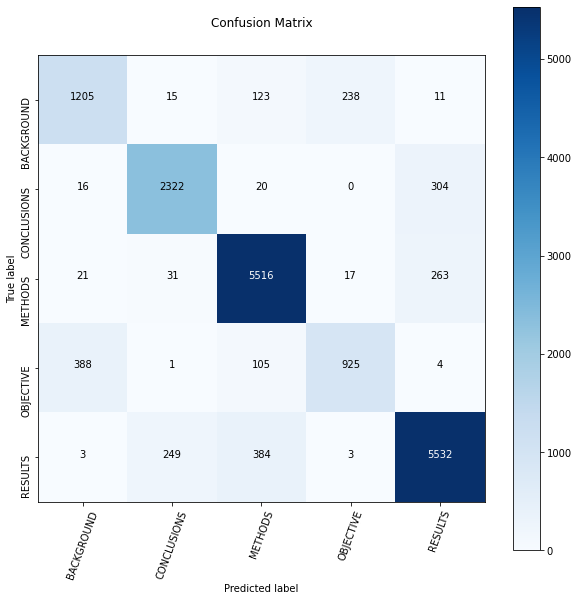

In [132]:
from dl_helper import make_confusion_matrix
make_confusion_matrix(y_true=val_labels_encoded,
                      y_pred=preds,
                      classes=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
                      text_size=10)

Looking at the conf matrix, it's getting confused with objective vs background

In [ ]:
pred_probs

In [136]:
predictions_df = pd.DataFrame({"Text": val_sentences,
                               "truth": class_names[val_labels_encoded],
                               "preds": class_names[preds],
                               "prob": np.max(pred_probs)})
predictions_df["Is pred correct"] = predictions_df['truth'] != predictions_df['preds']
predictions_df[:10]

,Text,truth,preds,prob,Is pred correct
0,patients stated that using vr made the treatme...,CONCLUSIONS,RESULTS,0.979387,True
1,"measurements and main outcome : relapse , defi...",METHODS,METHODS,0.979387,False
2,correction of subclinical coagulation disorder...,CONCLUSIONS,CONCLUSIONS,0.979387,False
3,"in addition , the stability of individual impl...",METHODS,METHODS,0.979387,False
4,plasma vitamin a concentrations remained uncha...,RESULTS,RESULTS,0.979387,False
5,a total of @ eligible patients with pt@-@a and...,METHODS,METHODS,0.979387,False
6,forty-five patients of t@dm with hypertension ...,METHODS,METHODS,0.979387,False
7,the safety profile of diapep@ was similar betw...,RESULTS,RESULTS,0.979387,False
8,the majority ( @ % ) had no or mild melasma ( ...,RESULTS,RESULTS,0.979387,False
9,a single experienced operator completed @ sono...,METHODS,METHODS,0.979387,False


In [145]:
# Getting only the wrong
wrong_df = predictions_df[predictions_df['Is pred correct'] == True]
top_100_wrong = wrong_df.sort_values(by="prob", ascending=False)[:100]
top_100_wrong

,Text,truth,preds,prob,Is pred correct
0,patients stated that using vr made the treatme...,CONCLUSIONS,RESULTS,0.979387,True
12093,the purpose of this pilot study was to develop...,METHODS,OBJECTIVE,0.979387,True
12041,we investigated the efficacy and safety of tic...,BACKGROUND,OBJECTIVE,0.979387,True
12054,we assessed whether the use of a high dose of ...,METHODS,OBJECTIVE,0.979387,True
12057,we hypothesized that a @:@ c : v ratio will de...,OBJECTIVE,BACKGROUND,0.979387,True
...,...,...,...,...,...
11298,during traditional abdominal and vaginal surge...,METHODS,RESULTS,0.979387,True
11294,hypoglycemia is a critical obstacle to the car...,OBJECTIVE,BACKGROUND,0.979387,True
11293,"between april @ and august @ , @ ( @ % ) of @ ...",RESULTS,METHODS,0.979387,True
11285,gabapentin may reduce these symptoms and help ...,OBJECTIVE,BACKGROUND,0.979387,True
